<center><img src="https://github.com/mattprish/portfolio/edit/main/Другие%20сюжеты%20DL%20(ПЗАД)/HW1_GAN_diffusions/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение



Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/magic1.jpg?raw=1" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/shower.jpg?raw=1" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/geo.jpg?raw=1" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/gamma_p.png?raw=1" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [ ]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи



Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [ ]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [ ]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [ ]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

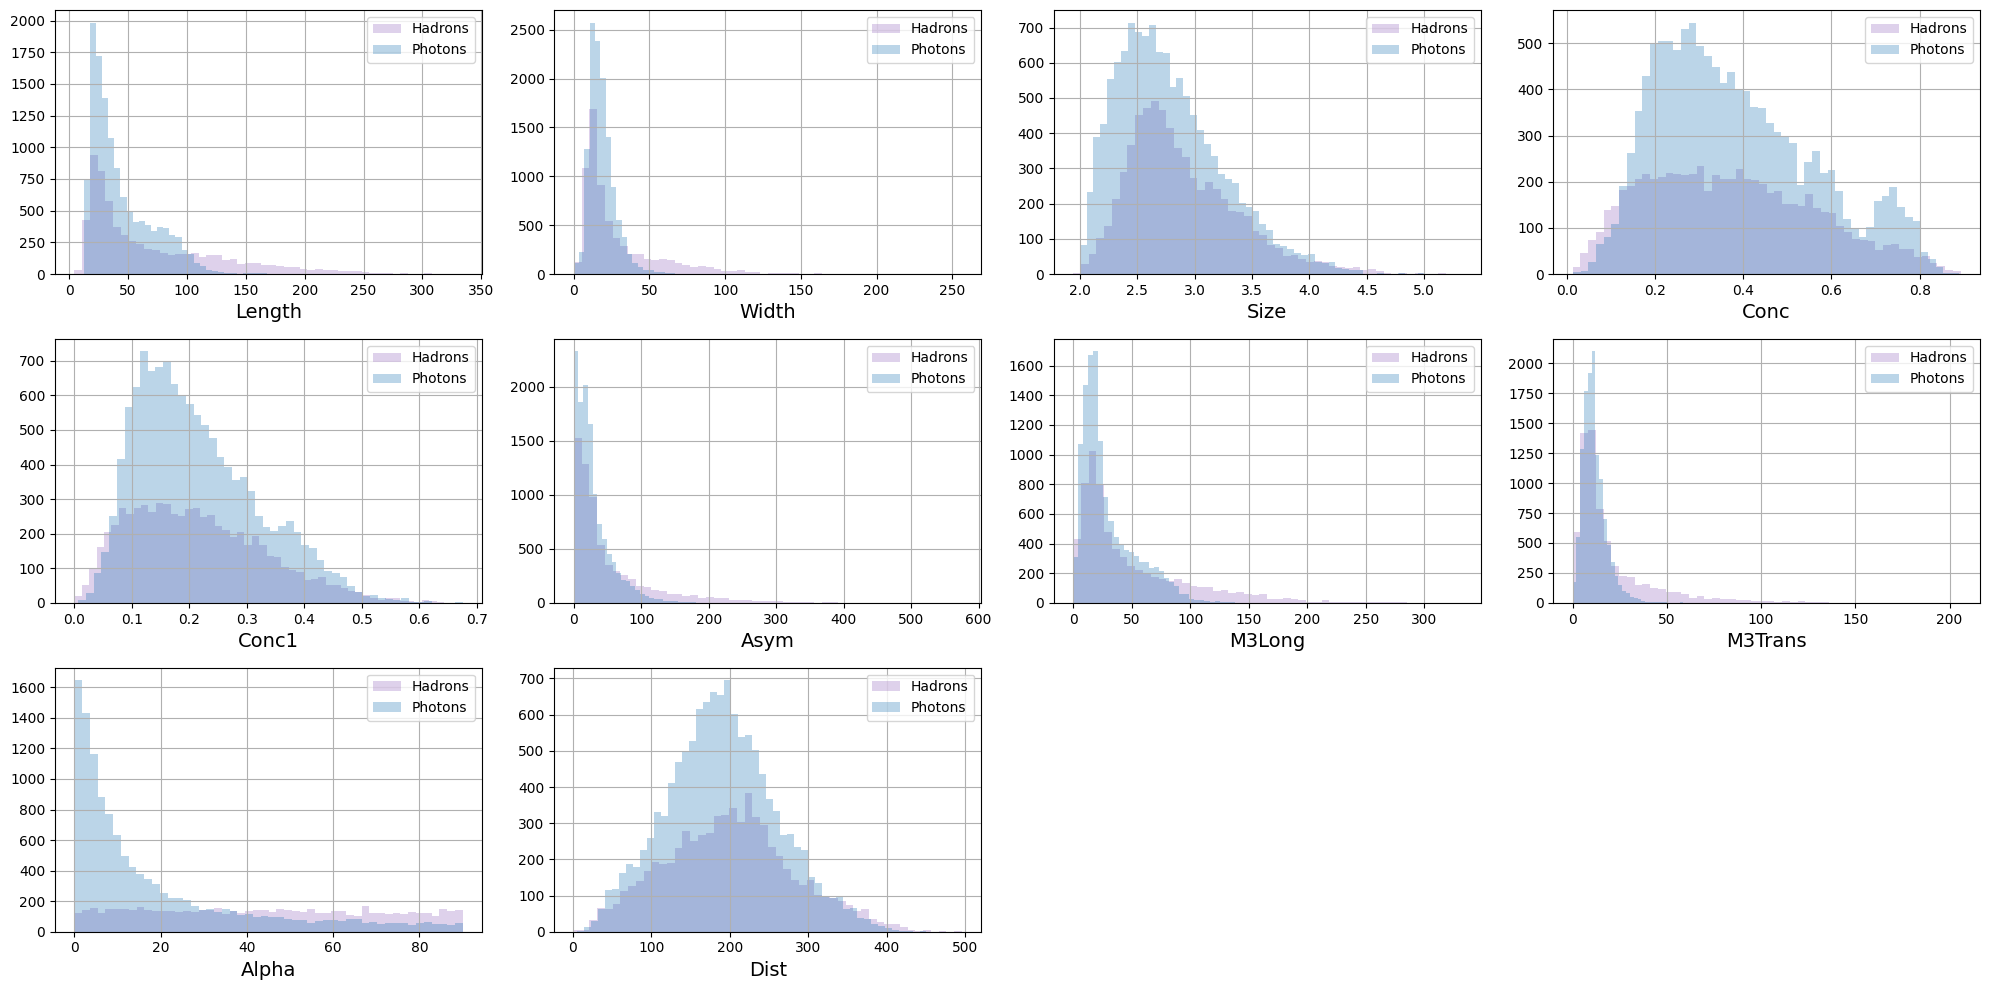

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [ ]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

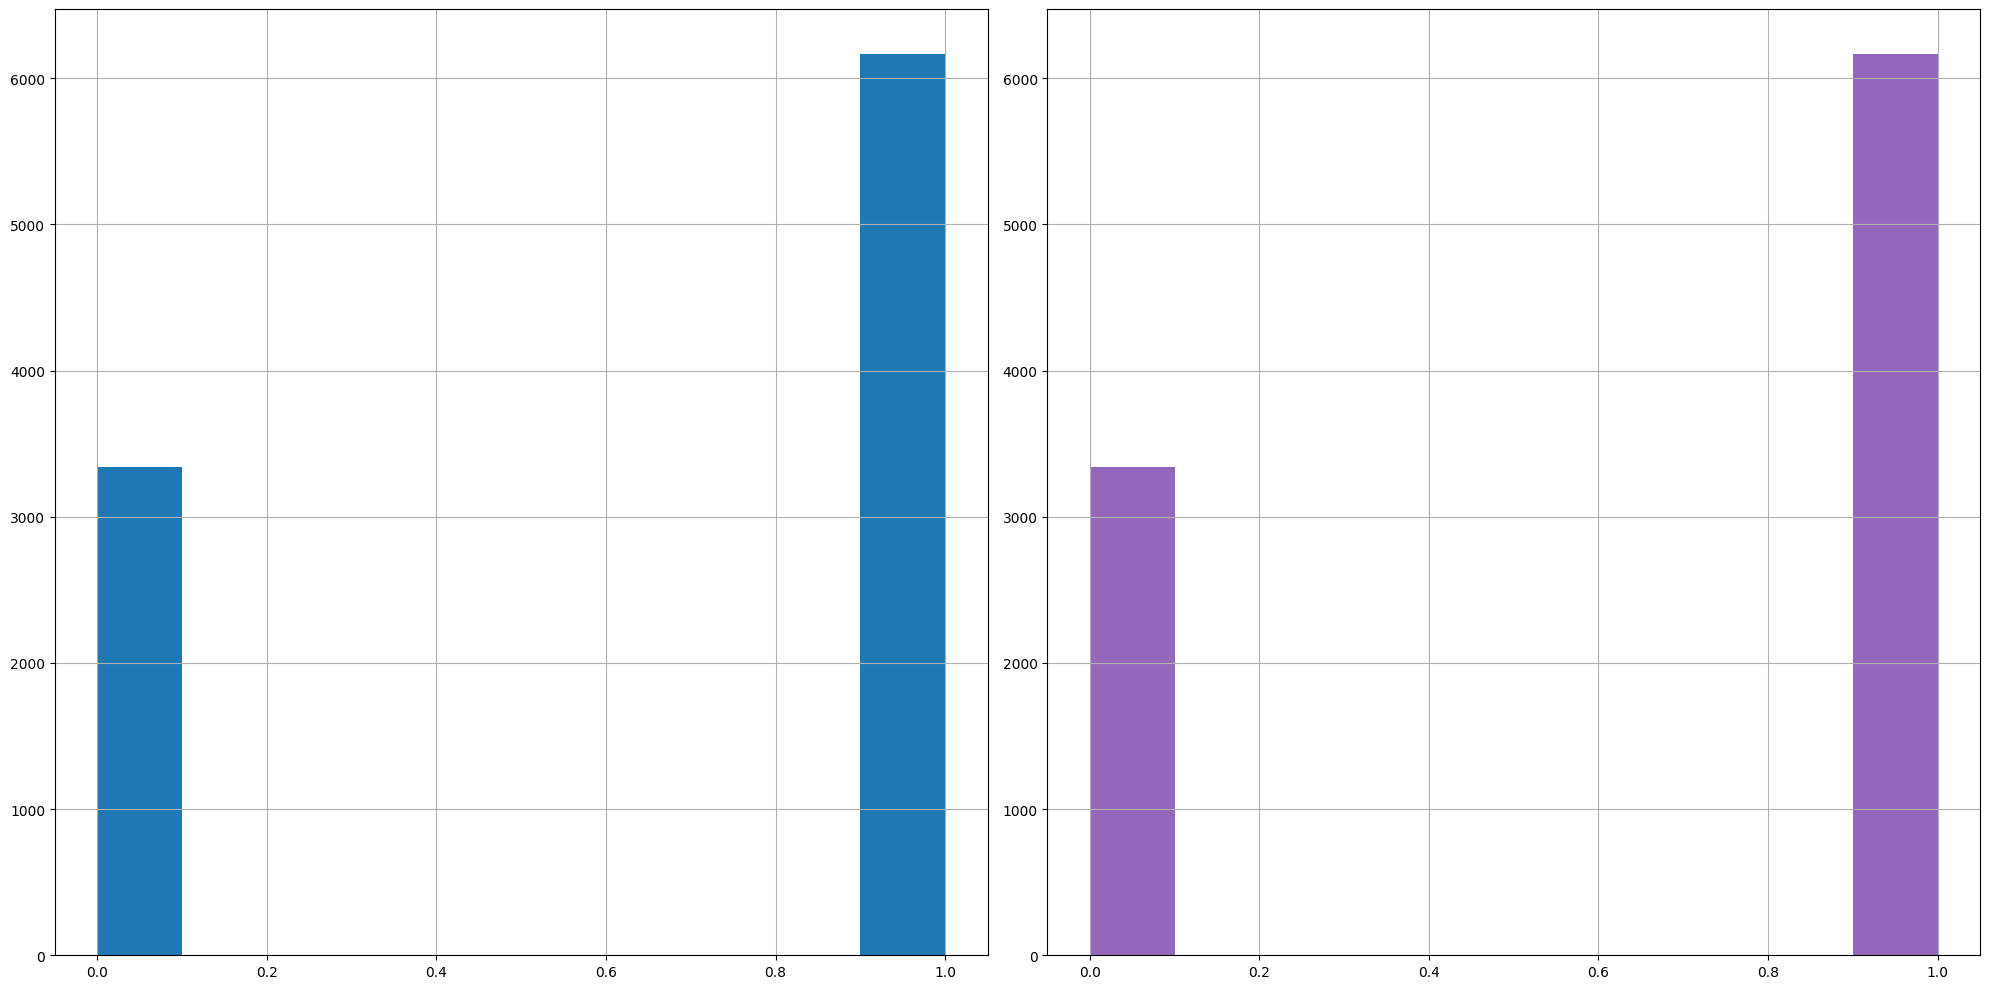

In [ ]:
plt.figure(figsize=(5 * 4, 5 * 2))

plt.subplot(1, 2, 1)
plt.grid()
plt.hist(y_train, label='train', color="C0")

plt.subplot(1, 2, 2)
plt.grid()
plt.hist(y_test, label='test', color="C4")
plt.tight_layout()

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [ ]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

In [ ]:
y_train[:, 0]

array([0., 0., 0., ..., 1., 1., 1.])

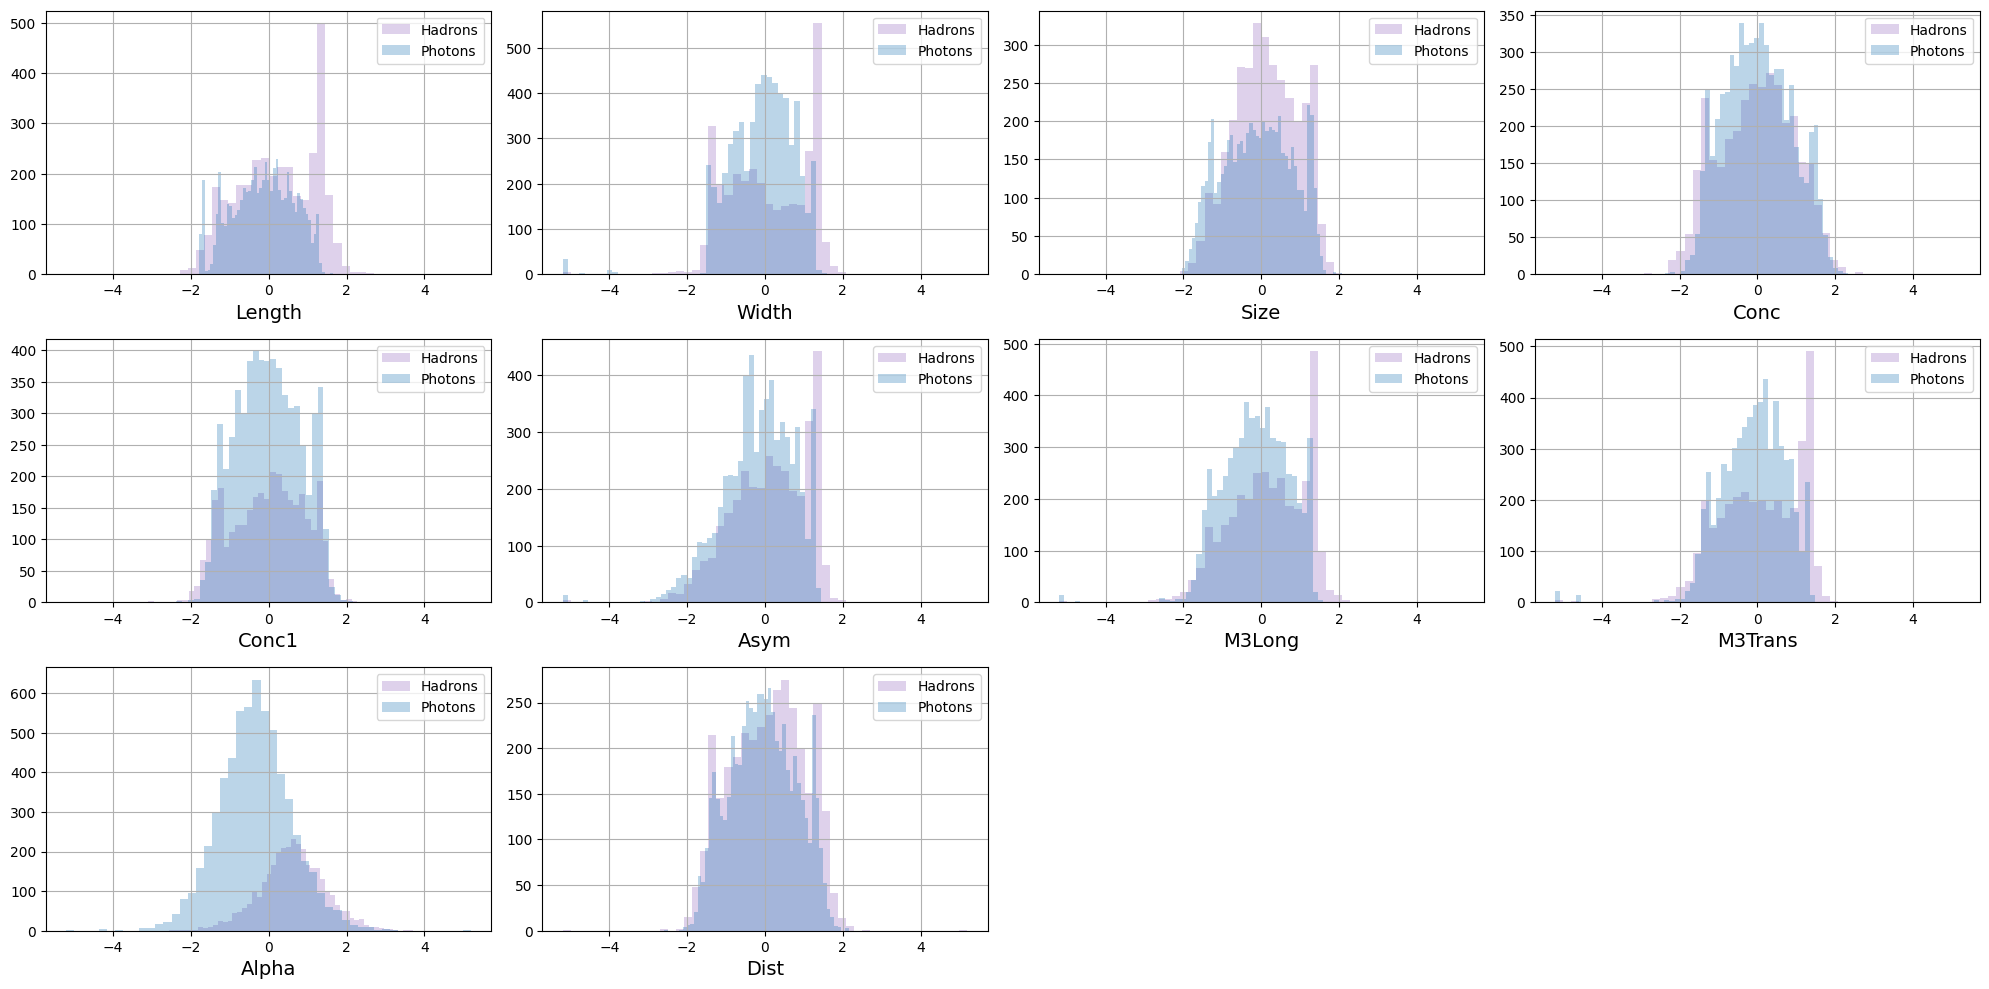

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
) # изучаем ситуацию в трейне

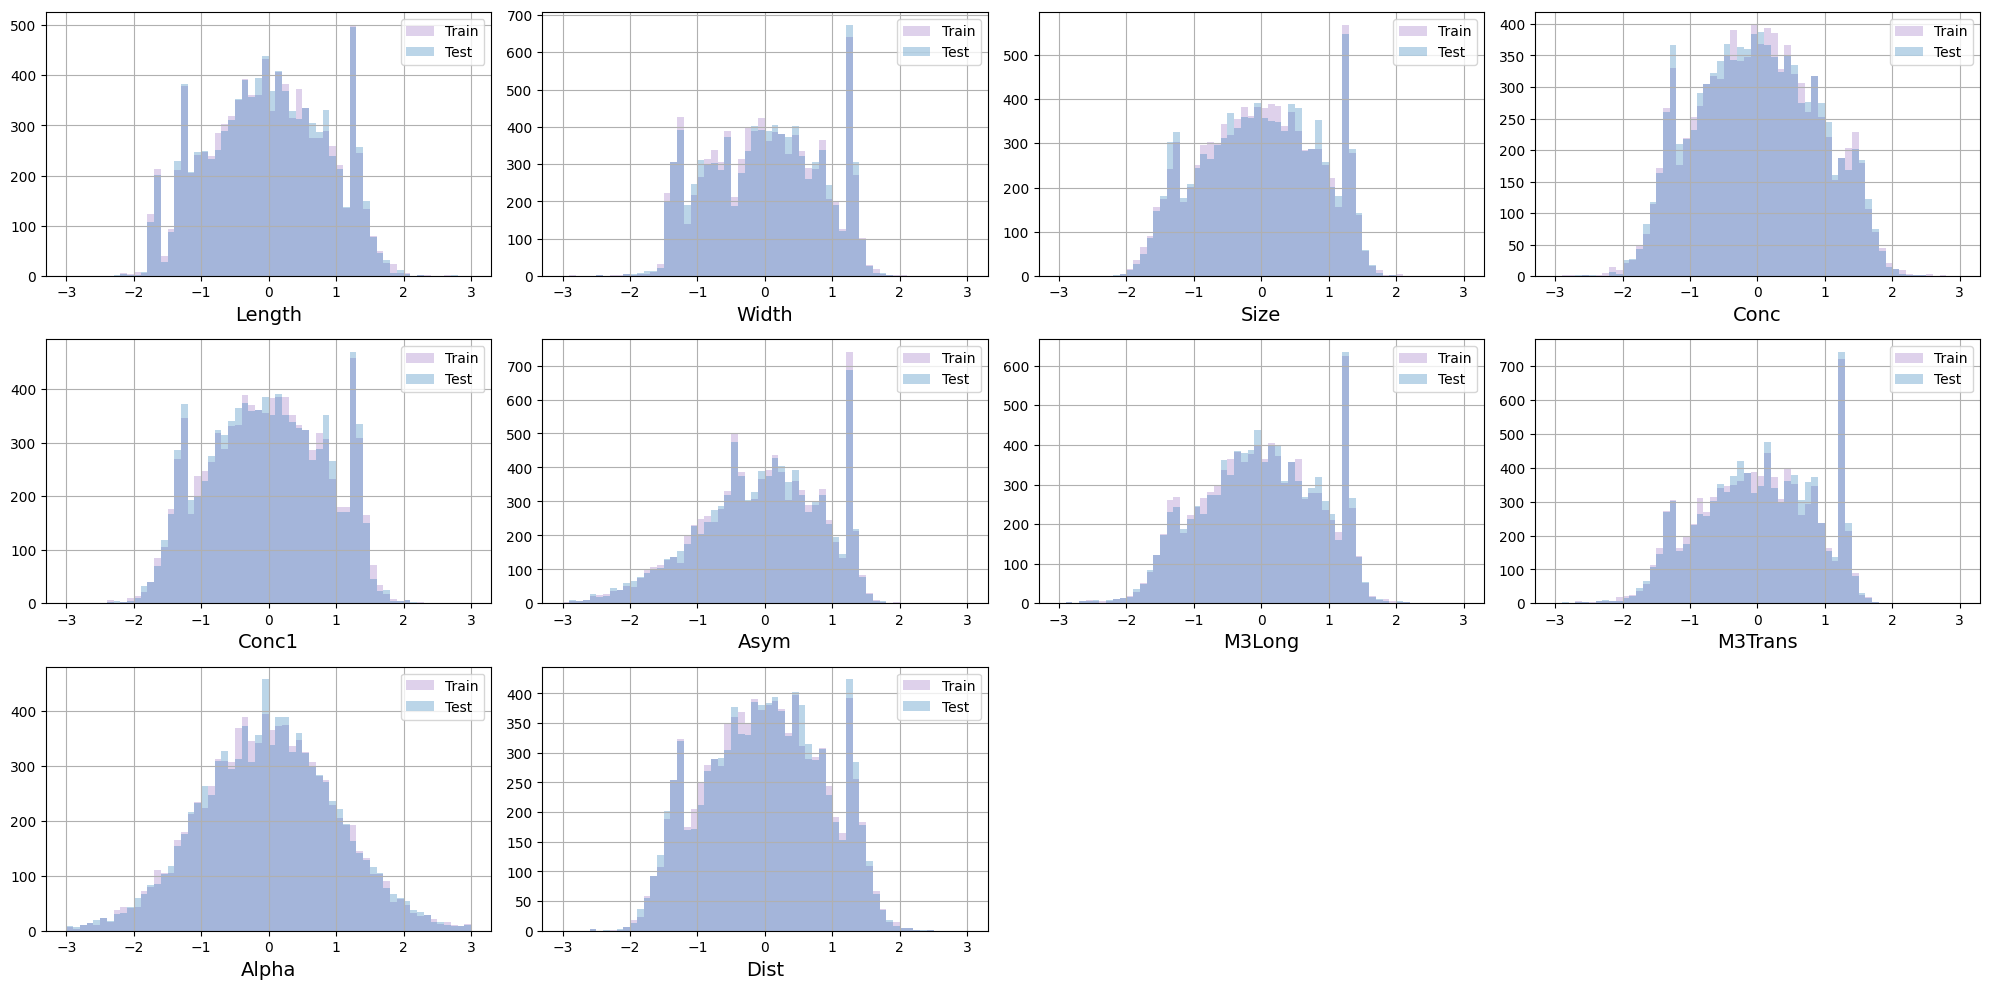

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")
# Трейн и тест распределены одинаково

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/cgan.png?raw=1" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )

    def forward(self, z, y):
        # if z.size()[0] != y.size()[0]:
        if z.shape[0] != y.shape[0]:
          id = min(z.size()[0], y.size()[0])
          zy = torch.cat((z[:id], y[:id]), dim=1)
          return self.net(zy)

        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [ ]:
def generate(generator, y, latent_dim):
    z = torch.normal(0, 1, (y.shape[0], latent_dim)).to(DEVICE)
    y = torch.Tensor(y).to(DEVICE)
    X_fake = generator(z, y)
    return X_fake

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )


    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [ ]:
np.unique(y_train, return_counts = 1)

(array([0., 1.]), array([3344, 6166]))

In [ ]:
# нам интересен accuracy < 65%, иначе ответ "всегда 1" будет выигрывать и без нашего классификатора

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def other_agent_score(X_real, y_real, X_fake, y_fake):

    X_fake = torch.cat((X_fake, y_fake.view(-1, 1)), dim=1)  # Объединяем фейковые объекты с метками
    X_real = torch.cat((X_real, y_real.view(-1, 1)), dim=1)  # Объединяем реальные объекты с метками

    y_fake_ = torch.ones(X_fake.shape[0]).to(DEVICE)  # Создаем тензор из единиц для фейковых объектов
    y_real_ = torch.zeros(X_real.shape[0]).to(DEVICE)  # Создаем тензор из нулей для реальных объектов

    X = torch.cat((X_fake, X_real)).cpu().detach().numpy()  # Объединяем фейковые и реальные объекты
    y = torch.cat((y_fake_, y_real_)).cpu().detach().numpy()  # Объединяем фейковые и реальные метки

    # Разделяем данные на тренировочные и тестовые
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, stratify=y)

    lr = LogisticRegression().fit(X_train, y_train)
    gb = GradientBoostingClassifier().fit(X_train, y_train)

    lin_reg_score = accuracy_score(lr.predict(X_test), y_test)
    boosting_score = accuracy_score(gb.predict(X_test), y_test)

    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))



## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [ ]:
# Бейзлайн

class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            n = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                noise = torch.normal(0, 1, (self.batch_size, self.latent_dim)).to(DEVICE)
                fake_batch = self.generator(noise, cond_batch)

                # считаем скоры
                real_fake_batch = torch.cat((real_batch, fake_batch), dim=0)
                double = torch.cat((cond_batch, cond_batch), dim=0)

                objects_scores = self.discriminator(real_fake_batch, double)
                real_objects_scores, gen_objects_scores = torch.split(objects_scores, [real_batch.shape[0], fake_batch.shape[0]])


                if n % self.n_critic == 0:

                    # обучаем генератор
                    self.opt_gen.zero_grad()
                    gen_loss = gen_objects_scores.mean()
                    gen_loss.backward()
                    self.opt_gen.step()

                else:

                    # обучаем дискриминатор
                    self.opt_disc.zero_grad()
                    disc_loss = torch.mean(- self.discriminator(fake_batch, cond_batch)) + torch.mean(self.discriminator(real_batch, cond_batch))
                    disc_loss.backward()
                    self.opt_disc.step()
                    for p in self.discriminator.parameters():#weight clipping
                      p.data.clamp_(-0.01, 0.01)

                n += 1


            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(-loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            Z_noise = torch.normal(0, 1, (1000, self.latent_dim)).to(DEVICE)
            idx = torch.IntTensor(np.random.choice(np.arange(len(X_real)), 1000, replace=False)).to(DEVICE)
            X_sample = X_real[idx]
            y_sample = y_cond[idx]
            X_fake = self.generator(Z_noise, y_sample)

            other_agent_score(X_sample, y_sample, X_fake, y_sample)

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [ ]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=50,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.68
Boosting score: 0.962
Linear regression score: 0.574
Boosting score: 0.92
Linear regression score: 0.548
Boosting score: 0.934
Linear regression score: 0.592
Boosting score: 0.894
Linear regression score: 0.624
Boosting score: 0.9
Linear regression score: 0.596
Boosting score: 0.838
Linear regression score: 0.516
Boosting score: 0.8
Linear regression score: 0.592
Boosting score: 0.796
Linear regression score: 0.544
Boosting score: 0.83
Linear regression score: 0.582
Boosting score: 0.784
Linear regression score: 0.508
Boosting score: 0.8
Linear regression score: 0.55
Boosting score: 0.738
Linear regression score: 0.558
Boosting score: 0.724
Linear regression score: 0.522
Boosting score: 0.716
Linear regression score: 0.502
Boosting score: 0.7
Linear regression score: 0.464
Boosting score: 0.732
Linear regression score: 0.48
Boosting score: 0.732
Linear regression score: 0.494
Boosting score: 0.72
Linear regression score: 0.486
Boosting score: 0.69
Linear r

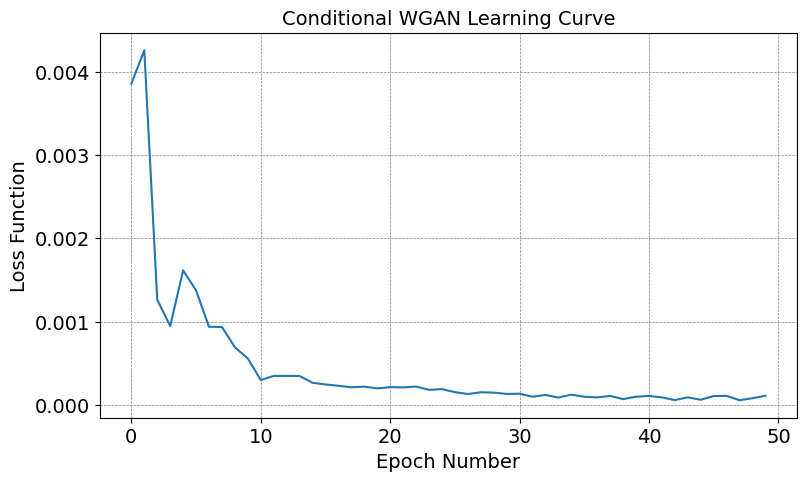

In [ ]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
# plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [ ]:
# X_train = qt.inverse_transform(X_train)
# X_test = qt.inverse_transform(X_test)

In [ ]:
X_fake_train = qt.inverse_transform(generate(fitter.generator, y_train, latent_dim).cpu().detach().numpy())

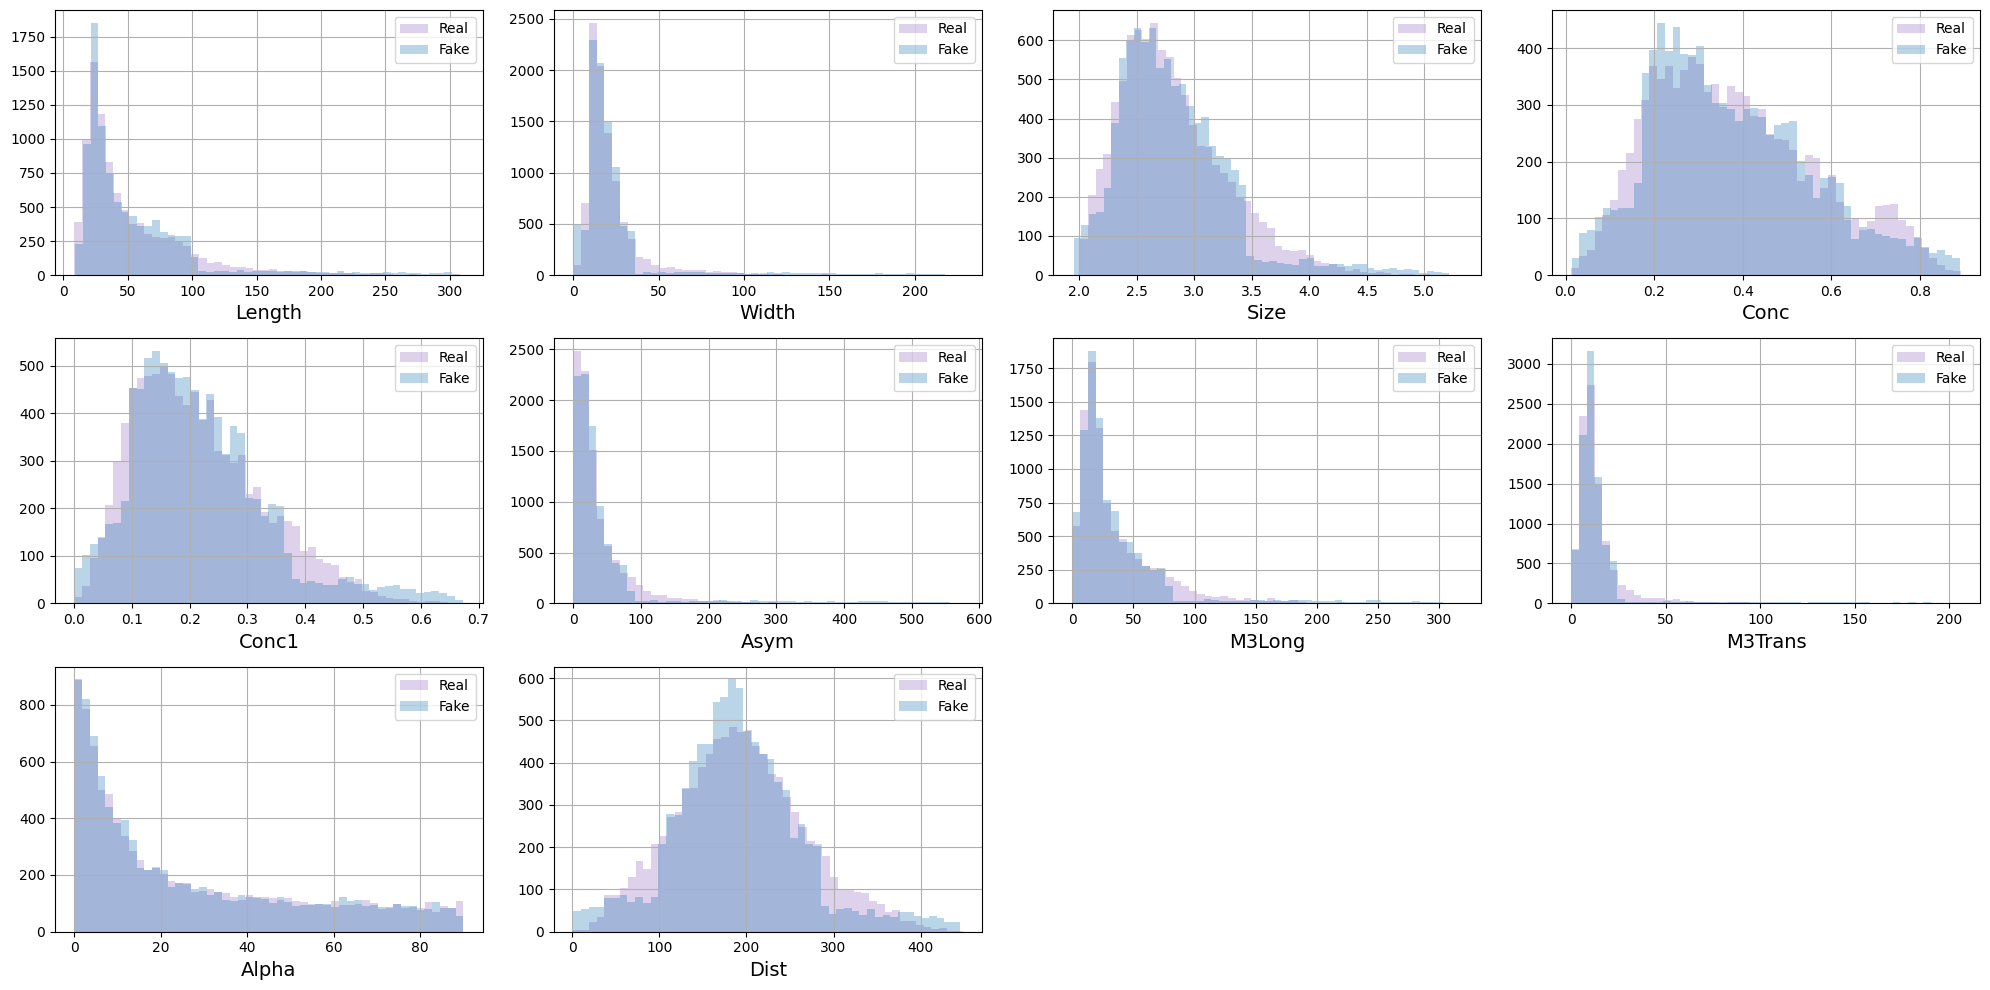

In [ ]:
plot_hists(qt.inverse_transform(X_train), X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [ ]:
X_fake_test = qt.inverse_transform(generate(fitter.generator, y_test, latent_dim).cpu().detach().numpy())

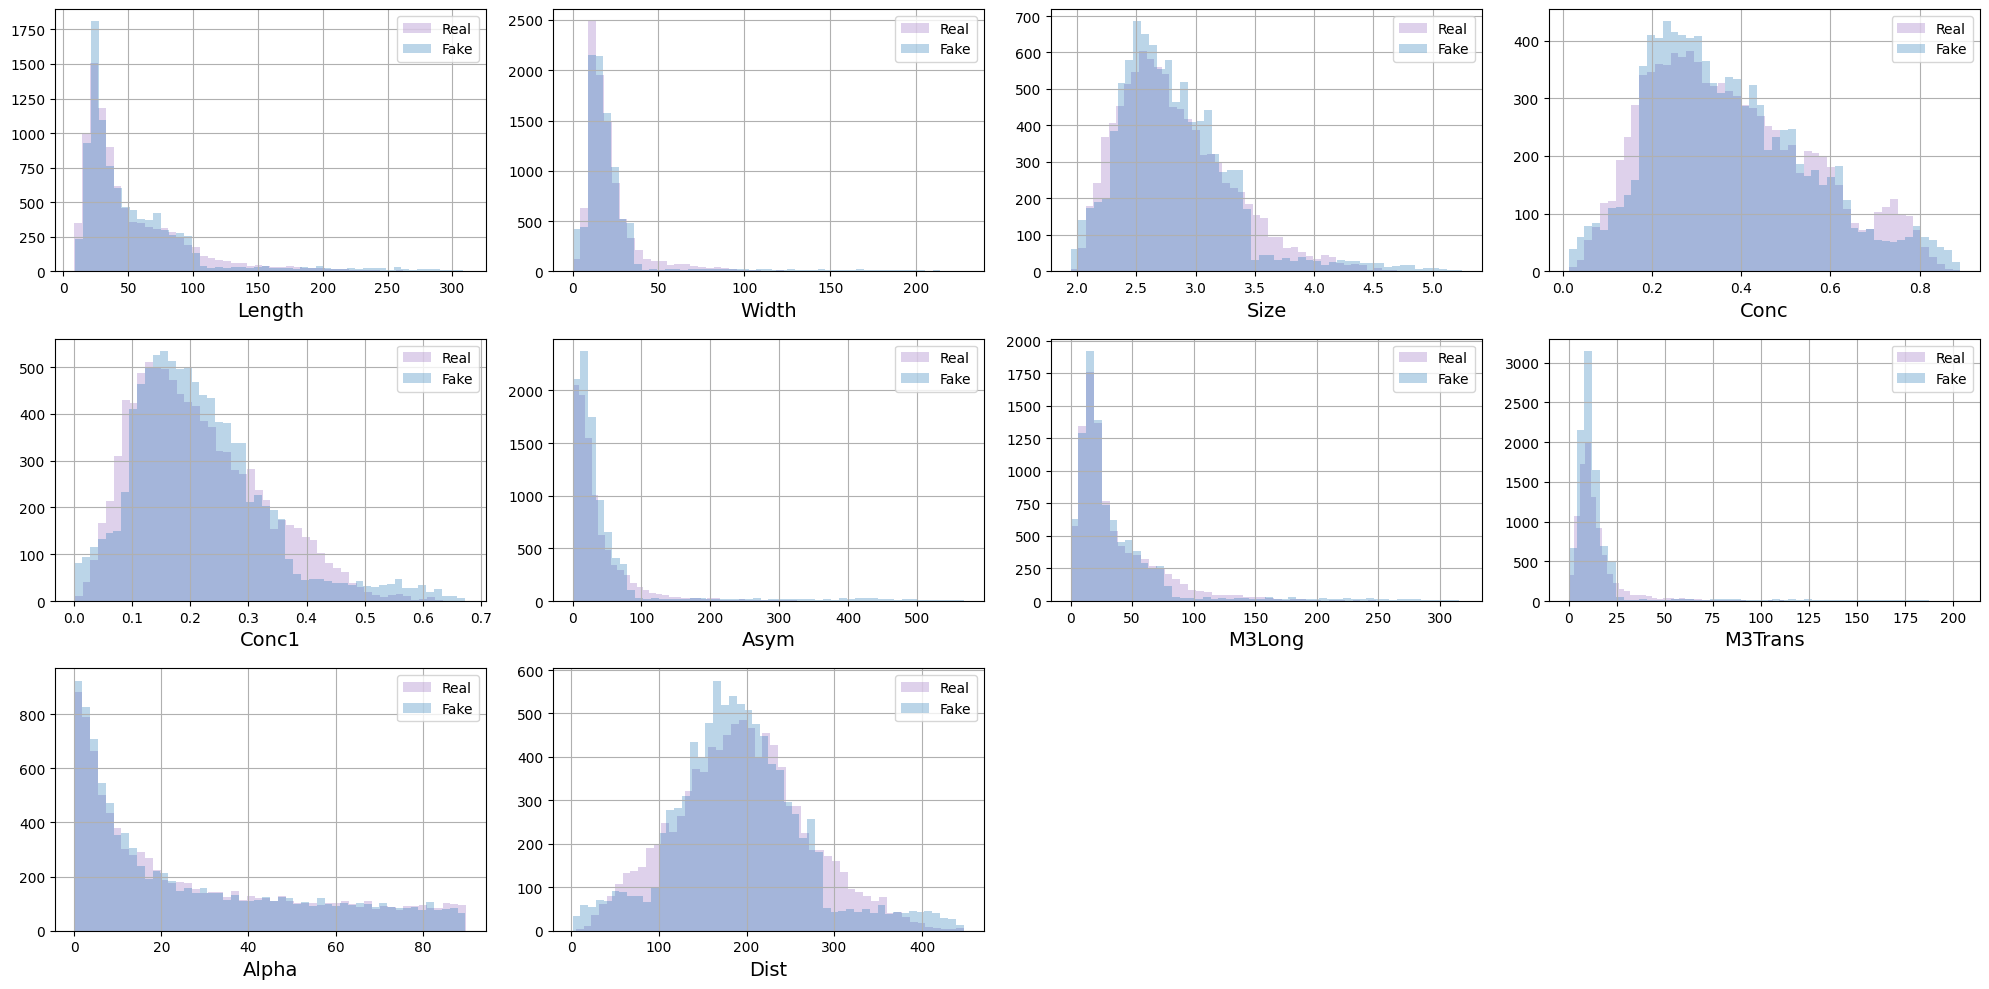

In [ ]:
plot_hists(qt.inverse_transform(X_test), X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

In [ ]:
# И не поспоришь

## Измерение качества генерации

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/clf.png?raw=1" width="600"></center>

Измерим сходство распределений классификатором.

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, qt.inverse_transform(X_train)), axis=0)
XX_test = np.concatenate((X_fake_test, qt.inverse_transform(X_test)), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [ ]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7979020534033022


In [ ]:
# Тут рокаук изгадился по сравнению с обучением, мб дело в обратном преобразовании

In [ ]:
# А вообще - круто! Да это ж круто!!

## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


In [ ]:
# В идеале было бы круто видеть рок аук около 0.5 - чтобы даже бустинг не мог превзойти случайный классификатор
# Это случилось бы, если бы мы оооооочень хорошо сгенерировали фейки
# Я в процессе много путался и много пробовал, и некоторые моменты понял не до конца, но результат хороший,
# потому что мы с ходу выбили неплохой скор на бустинге и отличный - на логреге

# Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# def corrupt(x, amount):
#     sc = MinMaxScaler().fit(x)
#     x = torch.Tensor(x).to(DEVICE)
#     noise = torch.rand_like(x).to(DEVICE)
#     noise = noise * torch.mean(x) * torch.std(x)
#     noise = sc.inverse_transform(noise)
#     x = x * (1 - amount) + noise * amount
#     return x

In [ ]:
def corrupt(x, amount):
    x = torch.Tensor(x).to(DEVICE)
    noise = torch.rand_like(x).to(DEVICE)
    noise = noise * torch.mean(x) * torch.std(x)
    x = x * (1 - amount) + noise * amount
    return x

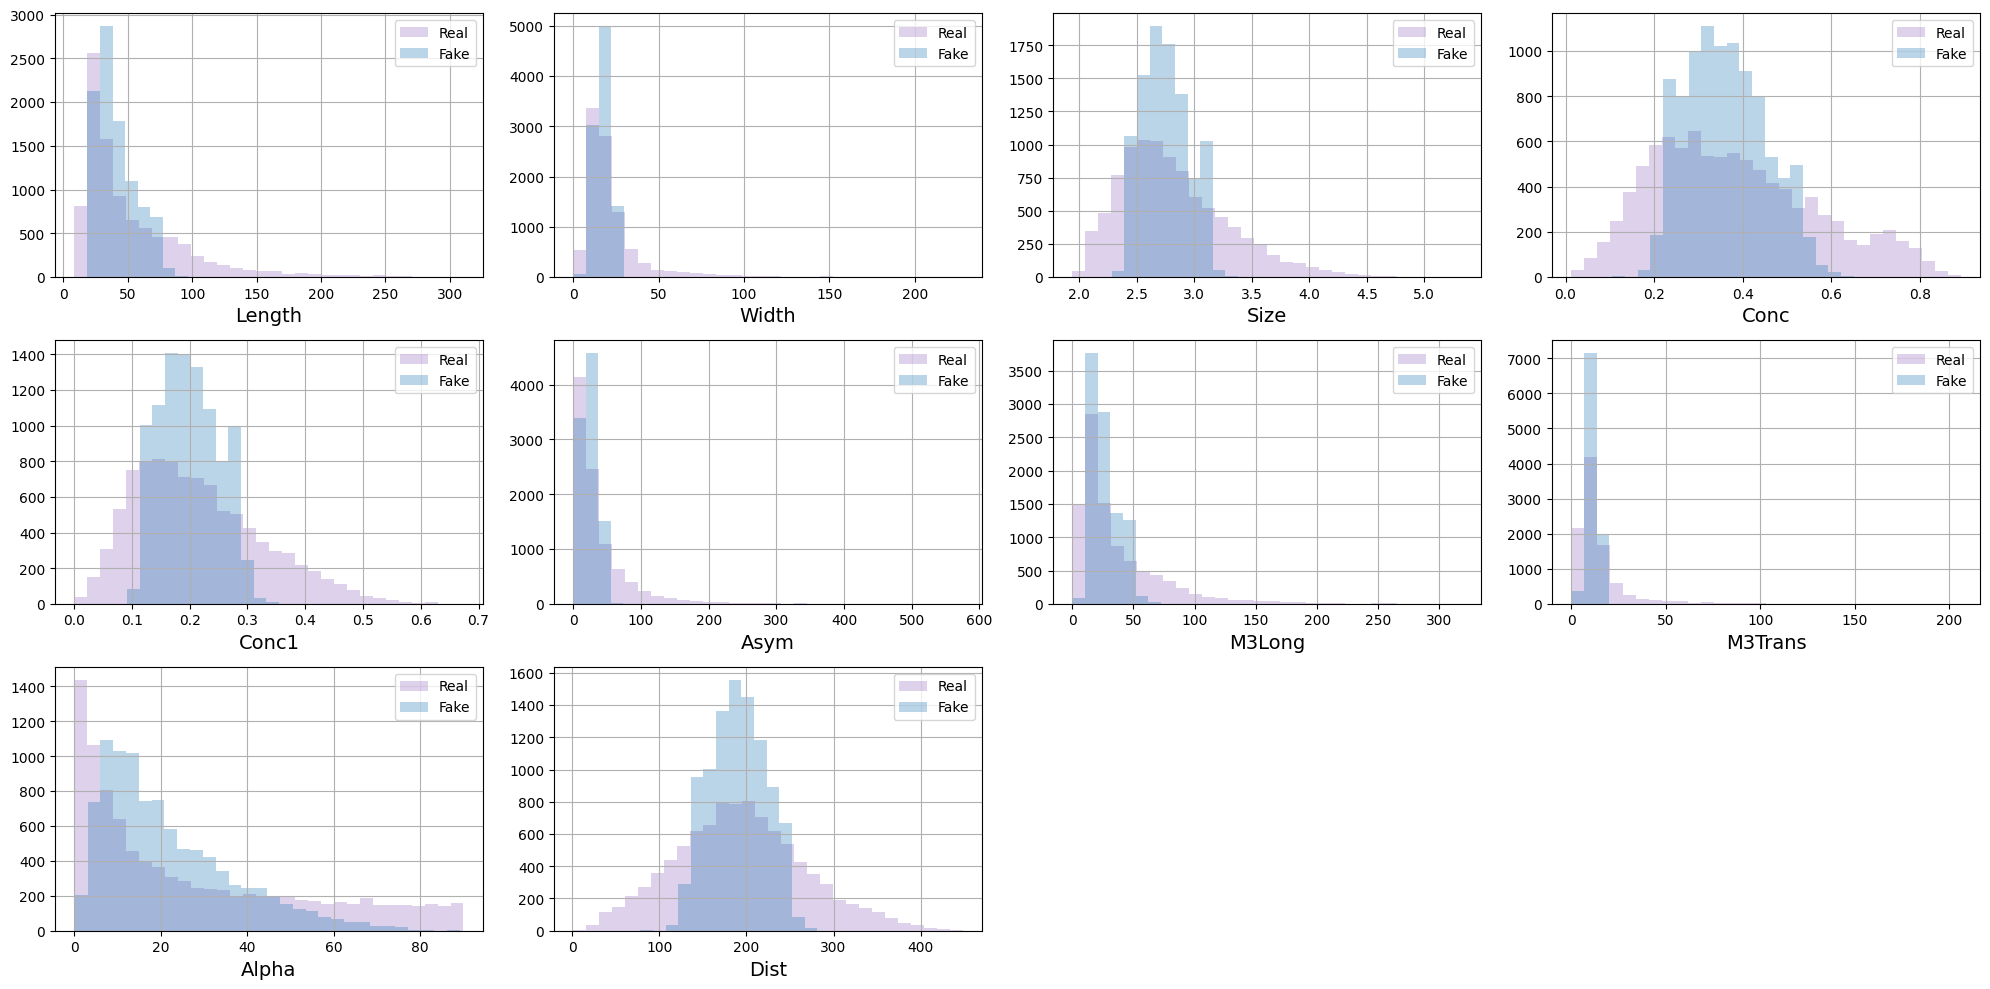

In [ ]:
plot_hists(
    qt.inverse_transform(X_train),
    qt.inverse_transform(corrupt(X_train, 0.5).cpu().detach().numpy()),
    names, label1="Real", label2="Fake", bins=30)

## Добавим sсheduler, он пригодится вам при обучении модели

In [ ]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.2 MB/s eta 0:00:00


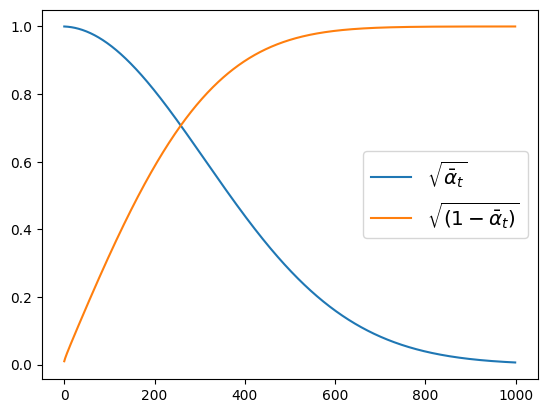

In [ ]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large");

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )

    def forward(self, z, y):
        if z.shape[0] != y.shape[0]:
          id = min(z.size()[0], y.size()[0])
          zy = torch.cat((z[:id], y[:id]), dim=1)
          return self.net(zy)

        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [ ]:
# бейзлайн
def generate(generator, y, latent_dim):
    z = torch.normal(0, 1, (y.shape[0], latent_dim)).to(DEVICE)
    y = torch.Tensor(y).to(DEVICE)

    for i, t in enumerate(noise_scheduler.timesteps[::200]):
      noise_amount = torch.Tensor(noise_scheduler.alphas_cumprod[t]).to(DEVICE)
      noisy_z = corrupt(z, noise_amount)
      z = generator(noisy_z, y)

    return z


## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [ ]:
import random
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.loss = nn.MSELoss()

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit дифузионка
        for epoch in range(self.n_epochs):
            if epoch % 10 == 0:
              print(f'epoch num {epoch}')
            loss_epoch = []
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # x = torch.cat((real_batch, cond_batch), 1)
                x = real_batch.to(DEVICE)

                # noise_amount = torch.rand(x.shape[0]).to(DEVICE)
                noise_amount = torch.Tensor(random.choice(noise_scheduler.alphas_cumprod)).to(DEVICE)
                noisy_batch = corrupt(x, noise_amount)

                pred = self.model(noisy_batch, cond_batch)#.sample УЧЕСТЬ t!!!
                loss = self.loss(pred, x)

                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                loss_epoch.append(loss.item())

            # calculate and store loss after an epoch

            self.loss_history.append(np.array(loss_epoch).mean())
            if epoch % 10 == 0:
              print(f'loss: {np.array(loss_epoch).mean()}')

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

              Z_noise = torch.normal(0, 1, (1000, self.latent_dim)).to(DEVICE)
              idx = torch.IntTensor(np.random.choice(np.arange(len(X_real)), 1000, replace=False)).to(DEVICE)
              X_sample = X_real[idx]
              y_sample = y_cond[idx]
              X_fake = self.model(Z_noise, y_sample)

              other_agent_score(X_sample, y_sample, X_fake, y_sample)

        # Turn off training
        self.model.train(False)

In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=50,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

epoch num 0
loss: 0.2360597491966492
Linear regression score: 0.516
Boosting score: 0.79
epoch num 10
loss: 0.07039372369412976
Linear regression score: 0.494
Boosting score: 0.742
epoch num 20
loss: 0.036755982464598734
Linear regression score: 0.48
Boosting score: 0.776
epoch num 30
loss: 0.04162939629122537
Linear regression score: 0.44
Boosting score: 0.788
epoch num 40
loss: 0.050245862634589224
Linear regression score: 0.476
Boosting score: 0.788
CPU times: user 41.9 s, sys: 709 ms, total: 42.6 s
Wall time: 1min 5s


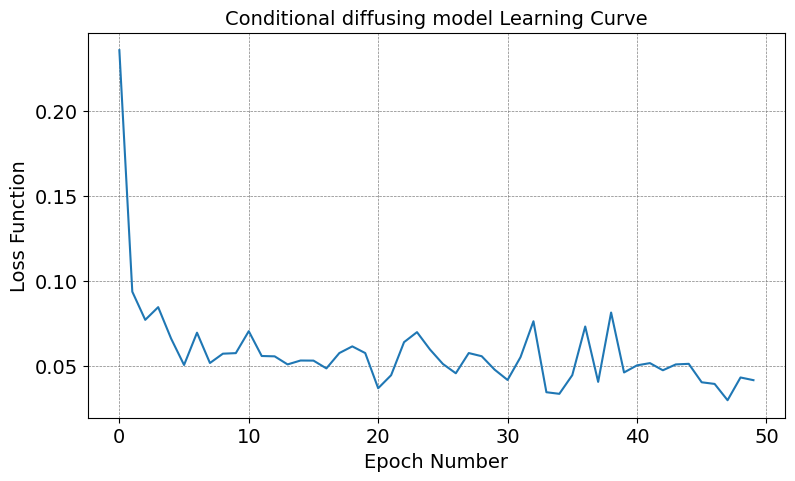

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

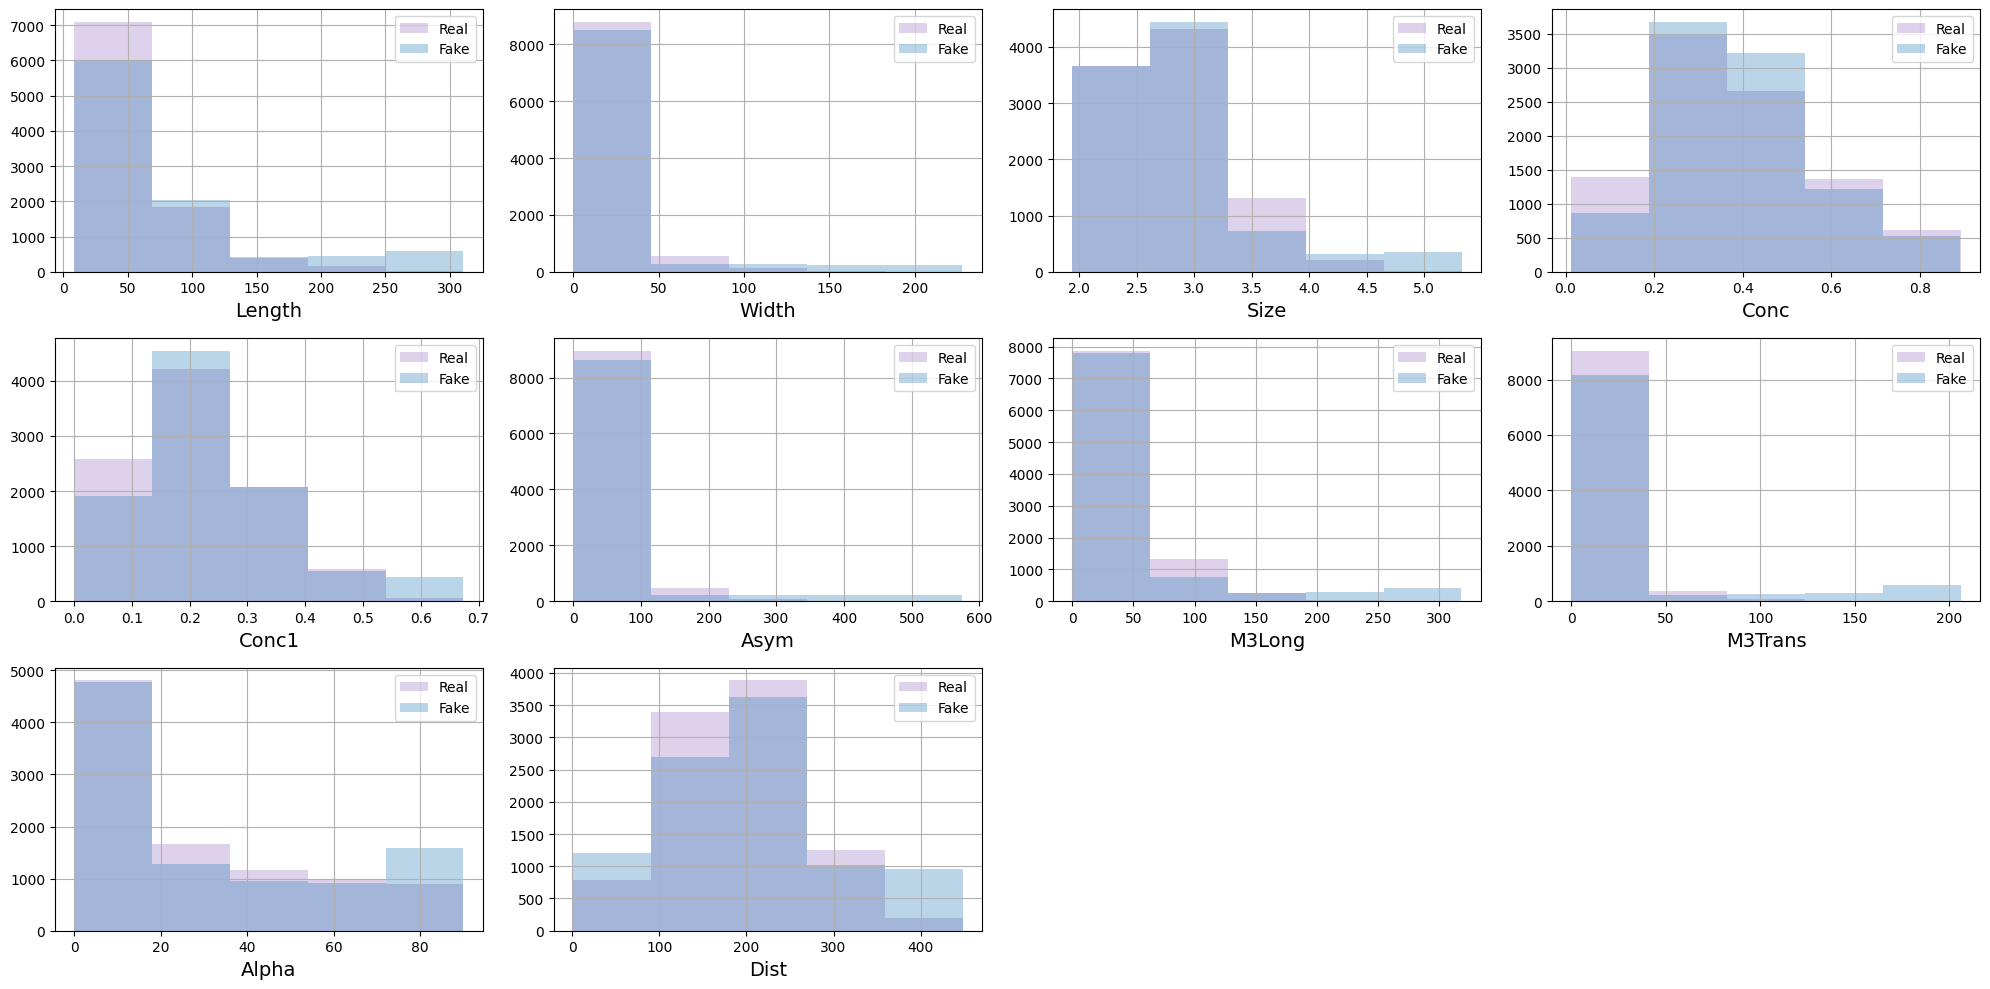

In [ ]:
X_fake_train2 = qt.inverse_transform(generate(diffusionFitter.model, y_train, latent_dim).cpu().detach().numpy())
plot_hists(qt.inverse_transform(X_train), X_fake_train2, names, label1="Real", label2="Fake", bins=5)

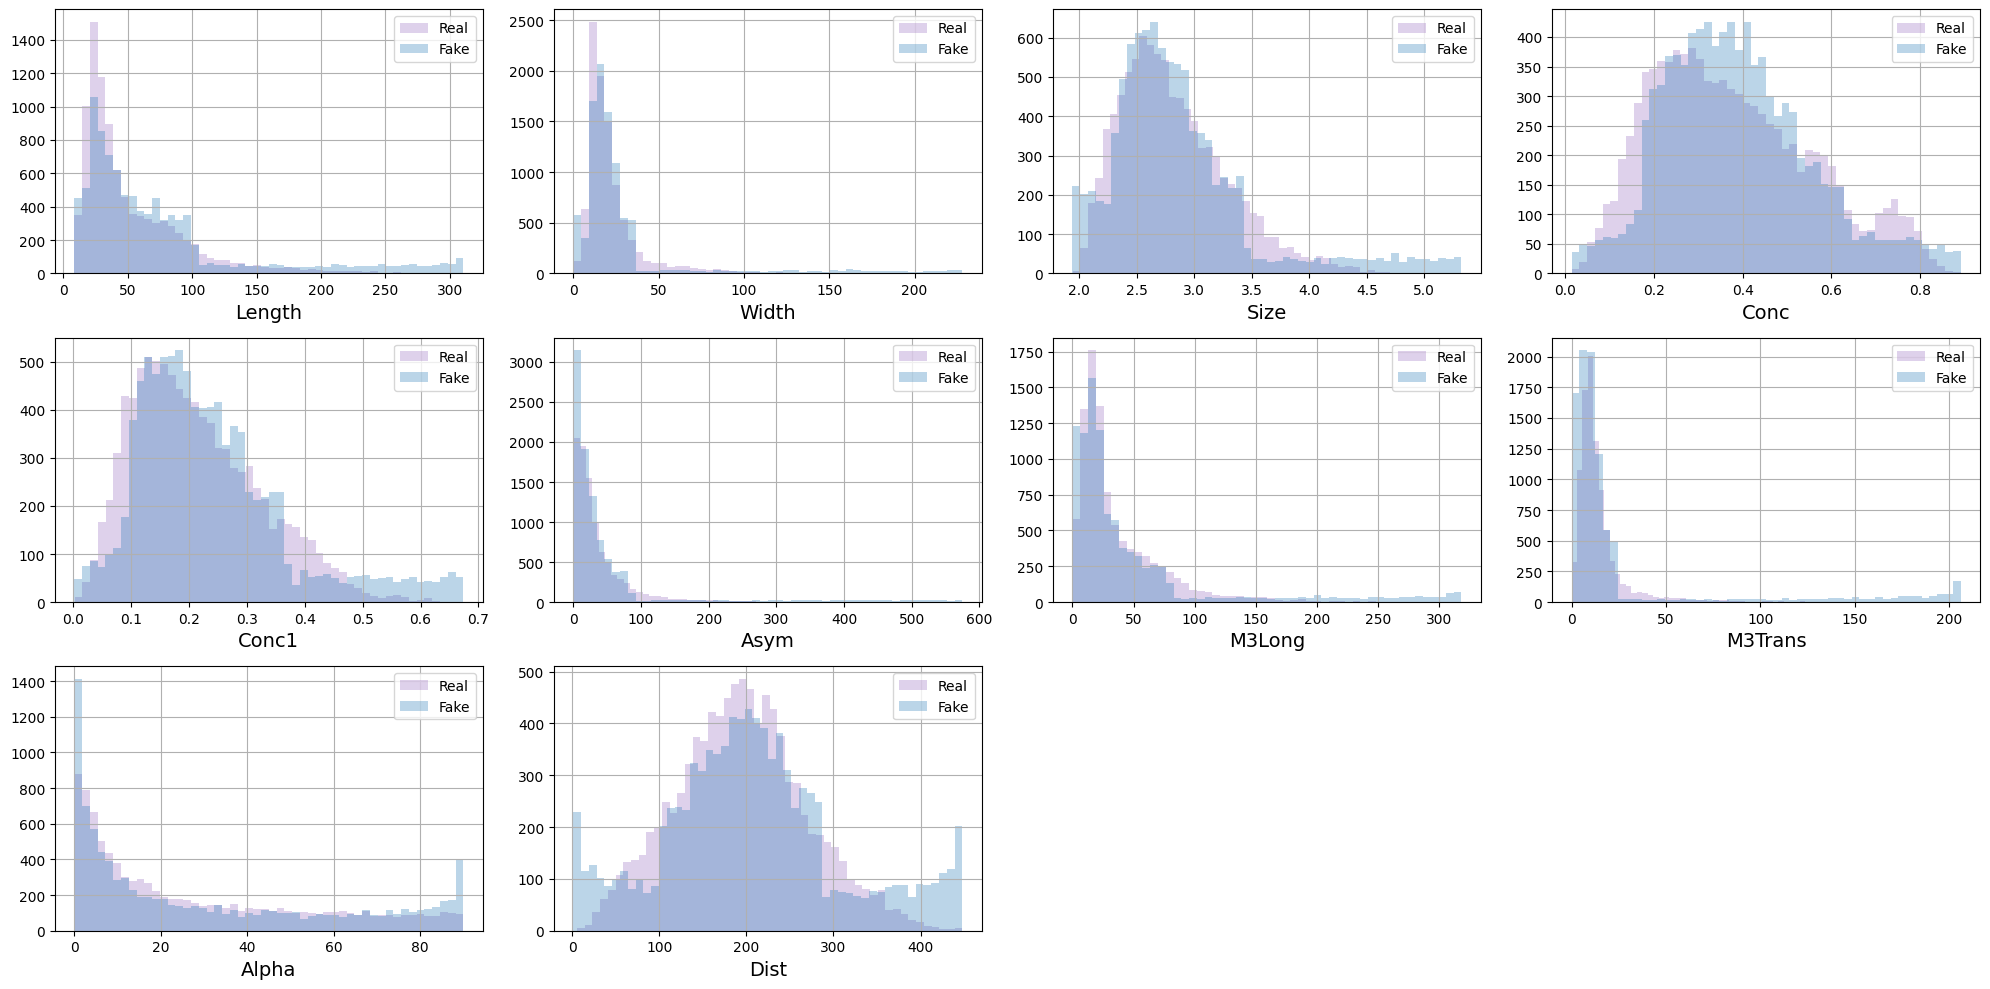

In [ ]:
X_fake_test2 = qt.inverse_transform(generate(diffusionFitter.model, y_test, latent_dim).cpu().detach().numpy())
plot_hists(qt.inverse_transform(X_test), X_fake_test2, names, label1="Real", label2="Fake", bins=50)

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train2, qt.inverse_transform(X_train)), axis=0)
XX_test = np.concatenate((X_fake_test2, qt.inverse_transform(X_test)), axis=0)

yy_train = np.array([0] * len(X_fake_train2) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test2) + [1] * len(X_test))

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

acc = accuracy_score(yy_test, clf.predict(XX_test))
auc = roc_auc_score(yy_test, yy_test_proba)

print("Accuracy = ", acc)
print("ROC AUC = ", auc)

Accuracy =  0.8829652996845426
ROC AUC =  0.9552185590241498


In [ ]:
# Во время обучение accuracy бустинга был меньше 75%, мб в конце что-то сломалось

In [ ]:
# Для диффузионки это кайф, мы могли бы улучшить результат, если бы сделали 1000 итераций вместо 5

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

In [ ]:
# топ, но я как будто стал глупее, на омо я мог гораздо больше :(